# Plotting

We introduce built-in plotting functions. 

A typical simulation requires visualizing:

1. geometry
2. simulation results
3. space-dependent arrays (such as eigenstates, charges, ...)

All public plotting functions are associated with a list of orbitals.

## Geometry

Geometries can be visualized in 2D or 3D.

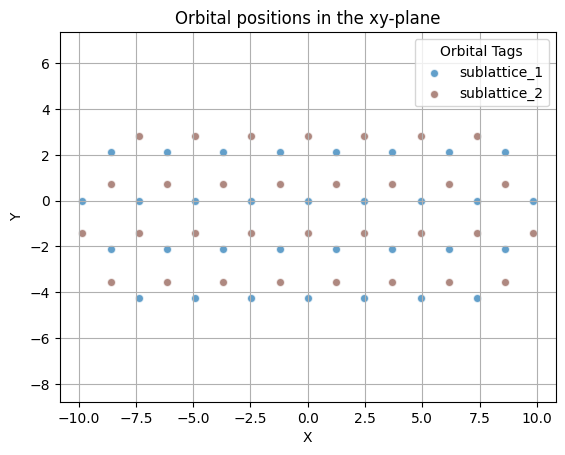

In [1]:
from granad import MaterialCatalog, Rectangle

flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake.show_2d()

If we have a stack

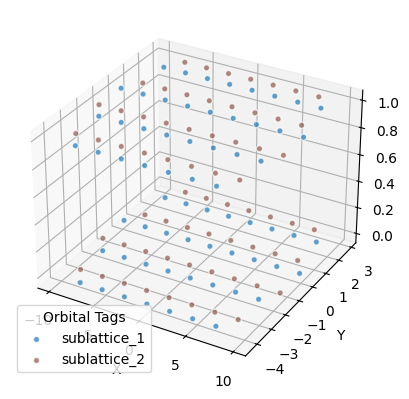

In [2]:
flake_shifted = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )
flake_shifted.shift_by_vector( [0,0,1] )
stack = flake + flake_shifted
stack.show_3d()

## Simulation output

There is a dedicated function for showing time-domain simulation results. Let's illustrate this by tracking the current considering the previously defined flake under x-polarized Gaussian pulsed illumination, which in GRANAD's units is equivalent to the velocity operator given by

$$\bf{v} = \frac{-i}{\hbar} [H, \bf{P}]$$

RHS compiled
RHS compiled


100.0 %


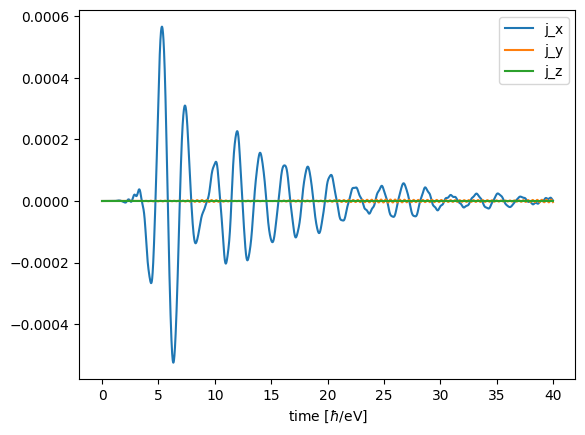

In [3]:
from granad import Pulse
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)
result = flake.master_equation(
    illumination=pulse,
    expectation_values = [flake.velocity_operator],
    end_time=40,
    relaxation_rate=1/10,
    grid=100, # save every 100-th time step
)
plot_labels = ['j_x', 'j_y', 'j_z'] 
flake.show_res( result, plot_labels = plot_labels )

A detailed description of parameters to the Gaussian pulse is given in the electric fields tutorial.

We can also Fourier transform the result to obtain the frequency domain result by specifying the omega limits

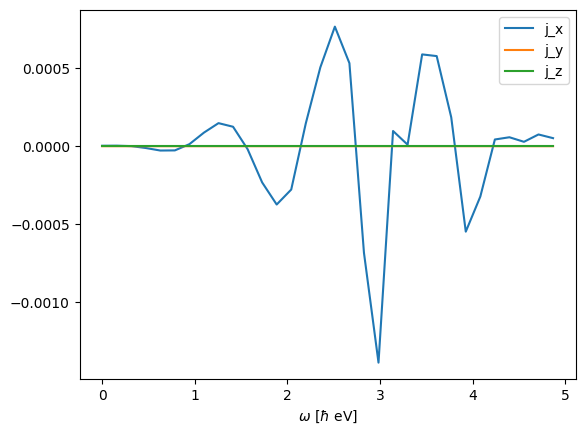

In [4]:
flake.show_res( result, omega_max = 5, omega_min = 0, plot_labels = plot_labels )

Note that the sparsity of the spectral grid ows to the sparse sampling in time domain which we have chosen for demonstrational purposes. A real simulation requires more careful refinement of the temporal grid.

## Space-dependent arrays

The functions show_2d and show_3d are a bit more versatile than initially indicated.

If we supply a "display" argument, we can plot an arbitrary array on the grid spanned by the orbitals and filter it by orbital tags. Let's demonstrate this by visualizing the lowest energy single-particle state of the flake

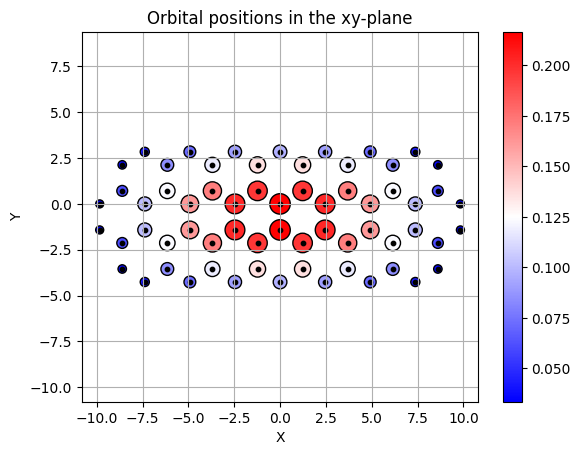

In [5]:
flake.show_2d( display = flake.eigenvectors[:, 0] )

If you want a normalized plot of the absolute values, do

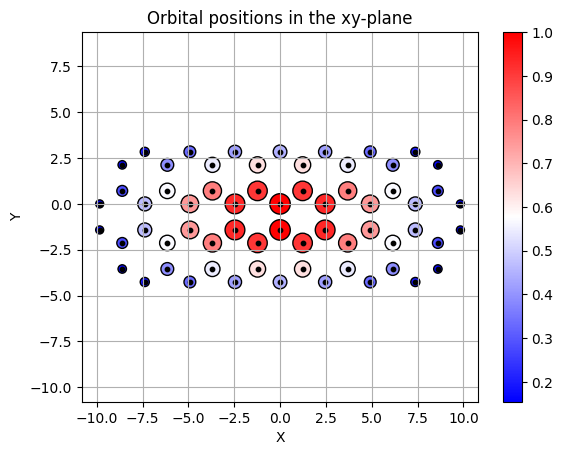

In [6]:
flake.show_2d( display = flake.eigenvectors[:, 0], scale = True )

Additionally, if you supply the keyword argument name = "MY-PLOT-NAME.pdf" to any plotting function, the plot will not be displayed, but instead saved to disk in the directory you invoked Python.